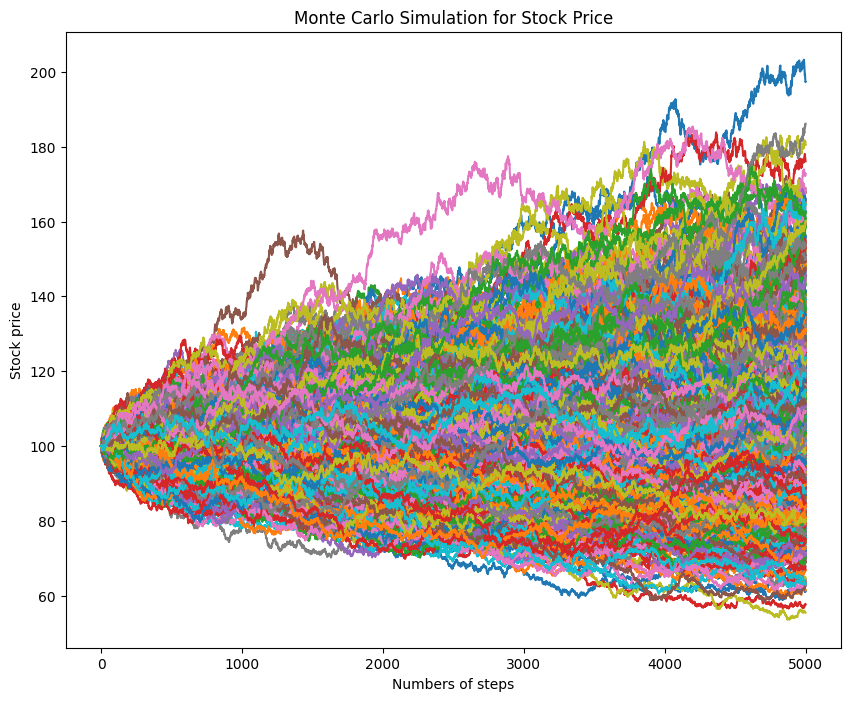

In [36]:
import math
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
import time
import tejapi

def montecarlo(S0, sigma, r, Npaths, N, T):
    
    S = np.zeros((Npaths, N+1))
    S[:, 0] = S0
    dt = T/ N
    for i in range(0,Npaths):
        for j in range(0,N):
            Z = np.random.normal(0,1)
            S[i, j+1] = S[i, j] * np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    return S

S0 = 100
sigma = 0.2
r = 0.05
Npaths = 1000
N = 5000
T = 1 
S = montecarlo(S0,sigma,r,Npaths,N,T)

plt.figure(figsize = (10,8))
for i in range(len(S)):
    plt.plot(S[i])
plt.xlabel('Numbers of steps')
plt.ylabel('Stock price')
plt.title('Monte Carlo Simulation for Stock Price')
plt.show()


In [37]:
def montecarlo_option(S0,K,CallOrPut,sigma,r, Npaths, N, T):
    S = montecarlo(S0,sigma,r,Npaths,N,T)
    if CallOrPut =='Call':
        payoff = np.maximum(S[:,-1] -K,0) # prix finaux de toutes les trajectoires et à chaque étape on prend le max entre Sfinal -K et 0
        return np.mean(payoff) * np.exp(-r*T) # actualisation
    else:
        payoff = np.maximum(K - S[:,-1],0)
        return np.mean(payoff) * np.exp(-r*T) 
        

# Example usage 
S0 = 100
sigma = 0.2
r = 0.05
Npaths = 1000 
N = 5000
T = 1 
K = 110
CallOrPut = 'Call'
p = montecarlo_option(S0, K, CallOrPut, sigma, r, Npaths, N, T)
print(p)        
        

        

5.845871370846455


In [38]:
#Antithetic 

def montecarlo_option_ant(S0, K, CallOrPut, sigma, r, Npaths, N, T):
    S1 = montecarlo(S0, sigma, r, Npaths//2, N, T)
    S2 = montecarlo(S0, sigma, r, Npaths//2, N, T)
    S1[:, 0],S2[:,0] = S0, S0
    dt = T / N
    for i in range(0, int(Npaths//2)):
        for j in range(0, N):
            Z = np.random.normal(0,1)
            S1[i, j+1] = S1[i, j] * np.exp((r -0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
            S2[i, j+1] = S2[i, j] * np.exp((r -0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * -Z)
    if CallOrPut == 'Call':
        C1 = np.maximum(S1[:, -1] -K, 0)
        C2 = np.maximum(S2[:, -1] -K, 0)
        return np.mean((C1+C2)/2) * np.exp(-r*T)
    else:
        P1 = np.maximum( K-S1[:,-1], 0)
        P2 = np.maximum( K-S2[:,-1], 0)
        return np.mean((P1+P2)/2) * np.exp(-r*T)
    
S0 = 100
sigma = 0.2
r = 0.05
Npaths = 1000 
N = 5000
T = 1 
K = 110
CallOrPut = 'Call'

C = montecarlo_option_ant(S0, K, CallOrPut, sigma, r, Npaths, N, T)
print(C)

5.744320513797725


In [39]:
# Control Variate  Z = X + c(Y - E[Y]) then c* = - Cov(X,Y) / Var(Y)

def montecarlo_option_CV(CallOrPut, K, S0, r, sigma, T, N, Nrep, Nc): 
    
    # Calculate covariance between stock and options price
    S1 = np.zeros((Nc, 1 + N))
    S1[:, 0] = S0
    dt = T / N
    for i in range(0,Nc):
        for j in range(0,N):
            Z = np.random.normal(0,1)
            S1[i, j+1] = S1[i, j] * np.exp((r -0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    Sn = S1[:, -1] 
    if CallOrPut == 'call':
        Cn = np.maximum(S1[:,-1] - K, 0) * np.exp(-r*T)
        MatCov = np.cov(Sn, Cn)[0,1] # Matrice de covariance dont on prend cov(x,y)
        VarY = S0 ** 2 * np.exp(2 * r * T) * (np.exp(T * sigma ** 2) - 1) # Black scholes variance de S(t=T)
        c = -MatCov / VarY # c optimal tq c = -COV(X,Y) / VAR(Y)
        E_Y = S0 * np.exp(r*T)
    else:
        Pn = np.maximum(K - S1[:,-1], 0) * np.exp(-r*T)
        MatCov = np.cov(Sn, Pn)[0,1]
        VarY = S0 ** 2 * np.exp(2 * r * T) * (np.exp(T * sigma ** 2) - 1)
        c = -MatCov / VarY
        E_Y = S0 * np.exp(r*T)

    
    # Applying control variate function with optimal c*
    S = np.zeros((Nrep, 1 + N))
    S[:, 0] =S0
    dt = T / N    
    for i in range(0,Nrep):
        for j in range(0,N):
            Z = np.random.normal(0,1)
            S[i, j+1] = S[i, j] * np.exp((r -0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    ST = S[:, -1] # tout les S à t = T ,  S final
    if CallOrPut == 'Call':
        C = np.maximum(ST - K, 0) * np.exp(-r*T)
        CVC = np.mean(C + c * (ST - E_Y))
        return CVC
    else:
        P = np.maximum(K - ST, 0) * np.exp(-r*T)
        CVP = np.mean(P + c * (ST - E_Y))
        return CVP
    
   # Example usage

S0 = 100
sigma = 0.2
r = 0.05
Npaths = 1000 
N = 5000
T = 1 
K = 110
CallOrPut = 'Call'

C = montecarlo_option_CV(CallOrPut, K, S0, r, sigma, T, N, Npaths, 1000)
   
print(C)

6.0416878736626405
